## **Subject** : Data Analytics and Machine Learning MIS 637
## **Project** : Credit Card Scam Detection







---

In [ ]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve

In [ ]:
# Reading CSV File
fraud_test = pd.read_csv('fraudTest.csv')
fraud_train = pd.read_csv('fraudTrain.csv')

In [ ]:
fraud_train.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0


In [ ]:
fraud_test.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0


In [ ]:
# Concatenating the two datasets
fraud_df = pd.concat([fraud_train, fraud_test]).reset_index()
fraud_df.drop(fraud_df.columns[:2], axis=1, inplace=True)

In [ ]:
# Display first 5 rows of data
fraud_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
fraud_df.shape

(1852394, 22)

## **Preprocessing**

* Here, we cannot incorporate DOB into our model, so will derive age from the same.
* Similarly, will derive hour, day, month and year form trans_date_trans_time column, because we cannot use date-time object to implement any Machine Learning model.

In [ ]:
# Checking datatype of trans_date_trans_time column
print(fraud_df.dtypes['trans_date_trans_time'])

object


In [ ]:
# Converting trans_date_trans_time into datetime
fraud_df['trans_date_trans_time'] = pd.to_datetime(fraud_df['trans_date_trans_time'])
print(fraud_df.dtypes['trans_date_trans_time'])
# fraud_data.head()

datetime64[ns]


In [ ]:
# Deriving age from 'dob' column
fraud_df['dob'] = pd.to_datetime(fraud_df['dob'])
fraud_df['age'] = np.round((fraud_df['trans_date_trans_time'] - fraud_df['dob'])/np.timedelta64(1, 'Y'))

# Deriving additonal columns from 'trans_date_trans_time' - hour, day, month-year
fraud_df['trans_hour'] = fraud_df['trans_date_trans_time'].dt.hour
fraud_df['trans_day_of_week'] = fraud_df['trans_date_trans_time'].dt.day_name()
fraud_df['trans_year_month'] = fraud_df['trans_date_trans_time'].dt.to_period('M')

fraud_df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,trans_hour,trans_day_of_week,trans_year_month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,31.0,0,Tuesday,2019-01
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,41.0,0,Tuesday,2019-01


In [ ]:
# Dropping columns
fraud_df.drop(['trans_date_trans_time', 'dob'] , axis=1, inplace=True)
print(len(fraud_df.columns))
print(fraud_df.columns)
print('------------------------------------------------------------------------------\n')

fraud_df.info()

24
Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'age',
       'trans_hour', 'trans_day_of_week', 'trans_year_month'],
      dtype='object')
------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column             Dtype    
---  ------             -----    
 0   cc_num             int64    
 1   merchant           object   
 2   category           object   
 3   amt                float64  
 4   first              object   
 5   last               object   
 6   gender             object   
 7   street             object   
 8   city               object   
 9   state              object   
 10  zip                int64    
 11  lat                float64  
 12  long     

Here, some of the columns' datatype is object and date-time period, which needs to be changed before implementing the models.

## **EDA (Exploratory Data Analysis)**
Now, will explore every features, so we can remove unnecessary data-columns and select only those data-columns which has significance to classify fraudy transactions. 

In [ ]:
# Describing every column
fraud_df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,age,trans_hour
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,4.626617e+01,1.280612e+01
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,1.741239e+01,6.815753e+00
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,1.400000e+01,0.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,3.300000e+01,7.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,4.400000e+01,1.400000e+01
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,5.700000e+01,1.900000e+01
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,9.600000e+01,2.300000e+01


In [ ]:
# Chechking for missing values
print(fraud_df.isnull().values.any())

False


In [ ]:
# Checking Target/Class variable frequency distribution
print(fraud_df['is_fraud'].value_counts())

0    1842743
1       9651
Name: is_fraud, dtype: int64


No Fraud 99.48 % of the dataset
Fraud 0.52 % of the dataset



Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

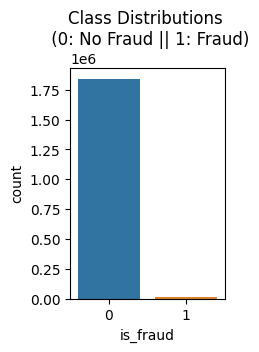

In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print("No Fraud", round(fraud_df['is_fraud'].value_counts()[0]/len(fraud_df) * 100,2), '% of the dataset')
print("Fraud", round(fraud_df['is_fraud'].value_counts()[1]/len(fraud_df) * 100,2), '% of the dataset\n')

# Plotting Target class data
fig = plt.figure()
fig.set_figwidth(2)
fig.set_figheight(3)

sns.countplot(x = fraud_df['is_fraud'])
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)')

In [ ]:
# Strating EDA from 'amt' column as it holds a lot of significance in credit card fraud analysis
pd.concat([fraud_df['amt'].describe().reset_index().rename(columns={'index': 'Distribution', 'amt':'Overall Distribution'}),
           fraud_df.loc[fraud_df['is_fraud']==0,['amt']].describe().reset_index(drop = 1).rename(columns={'amt':'Non-Fraud Distribution'}),
           fraud_df.loc[fraud_df['is_fraud']==1,['amt']].describe().reset_index(drop = 1).rename(columns={'amt':'Fraud Distribution'})], axis=1)

,Distribution,Overall Distribution,Non-Fraud Distribution,Fraud Distribution
0,count,1.852394e+06,1.842743e+06,9651.000000
1,mean,7.006357e+01,6.765128e+01,530.661412
2,std,1.592540e+02,1.535481e+02,391.028873
3,min,1.000000e+00,1.000000e+00,1.060000
4,25%,9.640000e+00,9.610000e+00,240.075000
5,50%,4.745000e+01,4.724000e+01,390.000000
6,75%,8.310000e+01,8.256000e+01,902.365000
7,max,2.894890e+04,2.894890e+04,1376.040000


Here, the mean/average of the 'fraud distribution' is way higher than the 'non-fraud distribution'. That means the amount lost in a fraud trnasaction is very high. Which is a usual behaviour looking at the real-life scenarios.

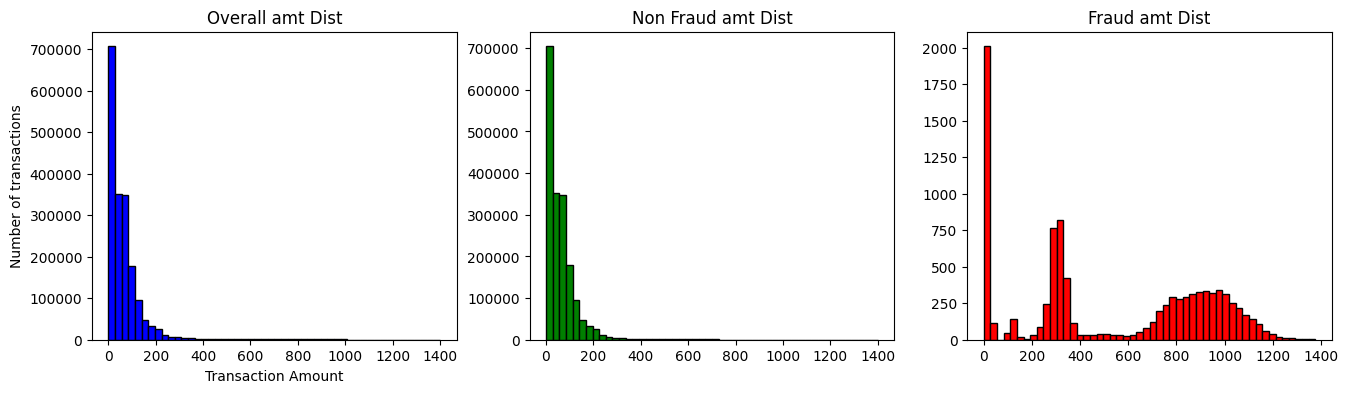

In [ ]:
# Plots to visualize the fraud vs non-fraud amount distribution
fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(4)

# Limiting amount at max fraud transaction for better visualization
plt.subplot(1, 3, 1)
plt.hist(fraud_df[fraud_df.amt <= 1400].amt, bins=50, color='blue', edgecolor='black')
plt.title('Overall amt Dist')
plt.xlabel('Transaction Amount')
plt.ylabel('Number of transactions')

plt.subplot(1, 3, 2)
plt.hist(fraud_df[(fraud_df.is_fraud==0) & (fraud_df.amt<=1400)].amt, bins=50, color='green', edgecolor='black')
plt.title('Non Fraud amt Dist')

plt.subplot(1, 3, 3)
plt.hist(fraud_df[(fraud_df.is_fraud==1) & (fraud_df.amt<=1400)].amt, bins=50, color='red', edgecolor='black')
plt.title('Fraud amt Dist')

plt.show()

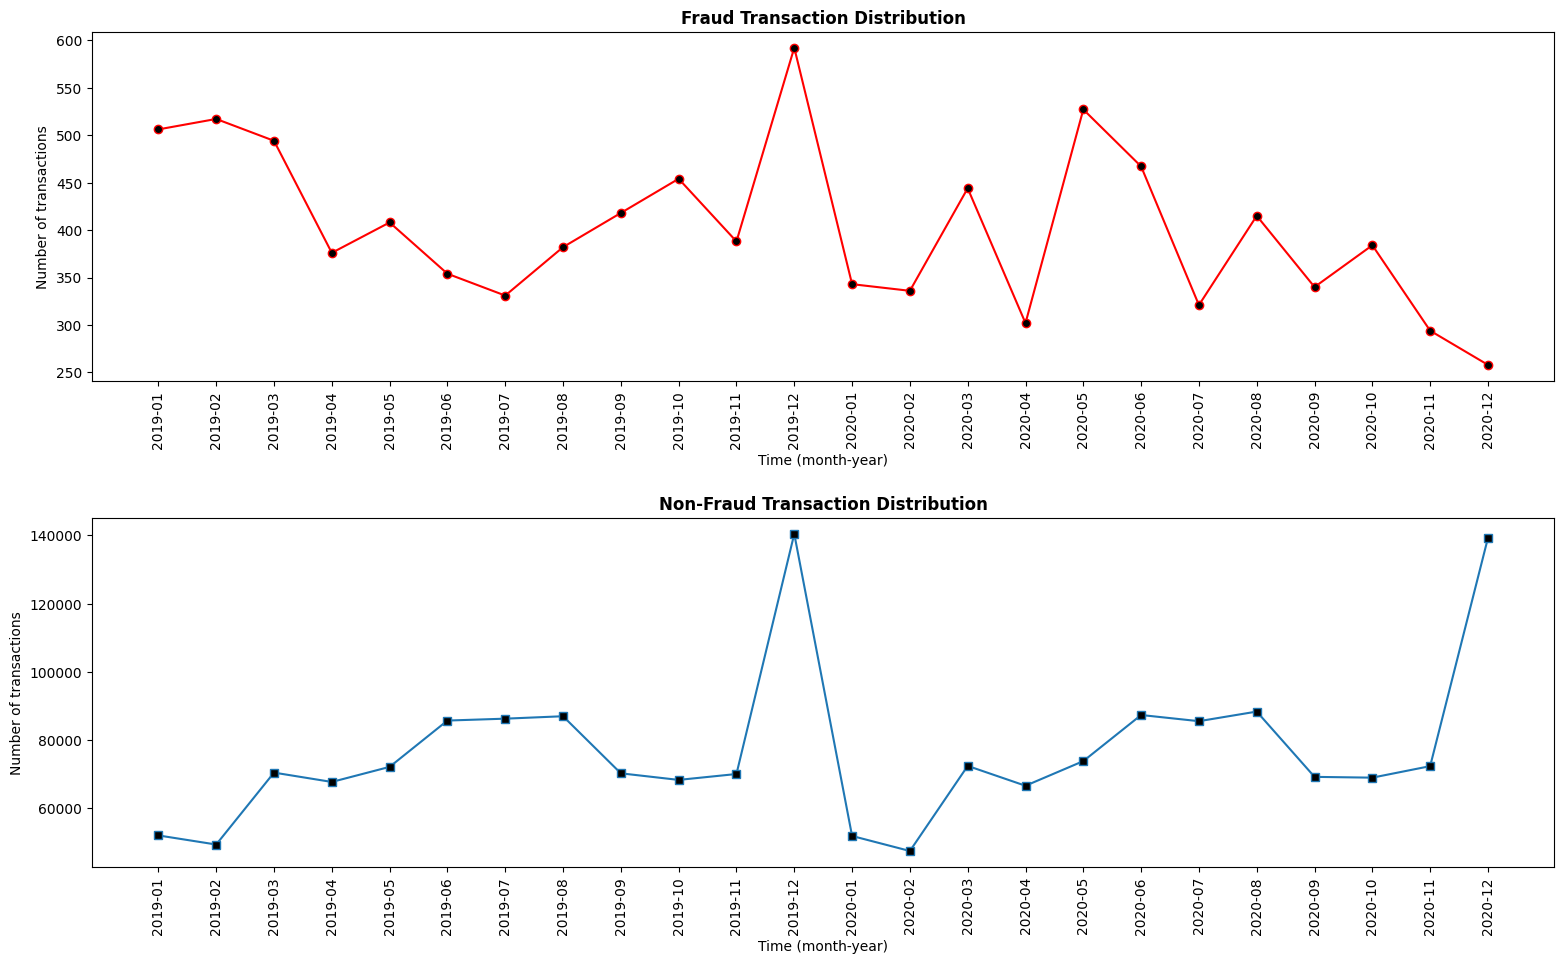

In [ ]:
# Now, exploring time (year_month) vs transactions

df_fraud_transactions = fraud_df[fraud_df['is_fraud']==1]
df_non_fraud_transactions = fraud_df[fraud_df['is_fraud']==0]

df_fraud_time = df_fraud_transactions.groupby(df_fraud_transactions['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_fraud_time.columns = ['year_month','num_of_transactions','customers']

df_non_fraud_time = df_non_fraud_transactions.groupby(df_non_fraud_transactions['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_non_fraud_time.columns = ['year_month','num_of_transactions','customers']

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(10)

x1 = np.arange(0,len(df_fraud_time),1)
x0 = np.arange(0,len(df_non_fraud_time),1)

plt.subplot(2, 1, 1)
plt.plot(x1, df_fraud_time['num_of_transactions'], marker='o', color='r', linewidth=1.5, mfc='k')
plt.xticks(x1, df_fraud_time['year_month'], rotation ='vertical')
plt.title('Fraud Transaction Distribution', fontweight='bold')
plt.xlabel('Time (month-year)')
plt.ylabel('Number of transactions')

plt.subplot(2, 1, 2)
plt.plot(x0, df_non_fraud_time['num_of_transactions'], marker='s', linewidth=1.5, mfc='k')
plt.xticks(x0, df_non_fraud_time['year_month'], rotation ='vertical')
plt.title('Non-Fraud Transaction Distribution', fontweight='bold')
plt.xlabel('Time (month-year)')
plt.ylabel('Number of transactions')

plt.tight_layout(pad=2.0)
plt.show()

<Axes: xlabel='gender', ylabel='count'>

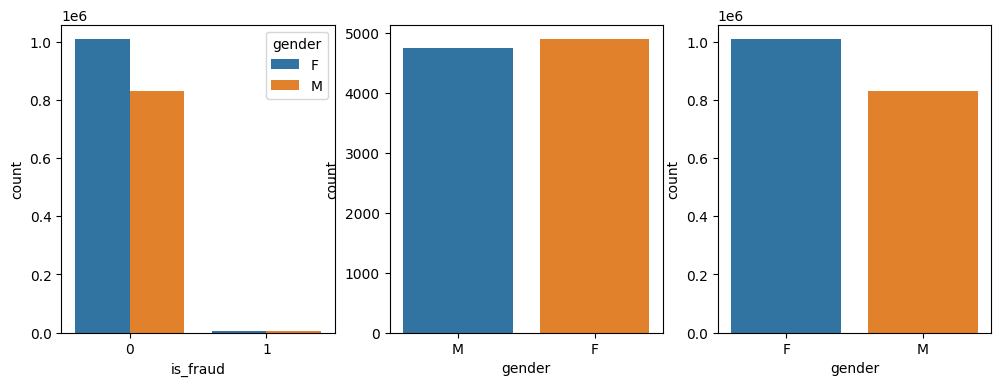

In [ ]:
# Plotting Target class data
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

plt.subplot(1, 3, 1)
sns.countplot(data=fraud_df, x="is_fraud", hue="gender")

plt.subplot(1, 3, 2)
sns.countplot(x = df_fraud_transactions['gender'])

plt.subplot(1, 3, 3)
sns.countplot(x = df_non_fraud_transactions['gender'])

Here, it can be seen that female has done more transactions compared to male, but both gender has faced almost equal number of fraud transactions.

In [ ]:
# Now, moving towards age
# Here, age is in continuous having min value 14 and max 96
# So, will categorize it in 3 groups (11-40, 41-70, 71-100)

# for i in range(len(fraud_df.age)):
#   if fraud_df.age[i] <= 40:
#     fraud_df.age[i] = 1.0
#   elif fraud_df.age[i] > 40 and fraud_df.age[i] <= 70:
#     fraud_df.age[i] = 2.0
#   else:
#     fraud_df.age[i] = 3.0

# fraud_df.age.head()

This step also covers feature encoding for age, but it takes huge amount of time and processing power to make it happen
<br>So, keeping age feature as it is, will move forward

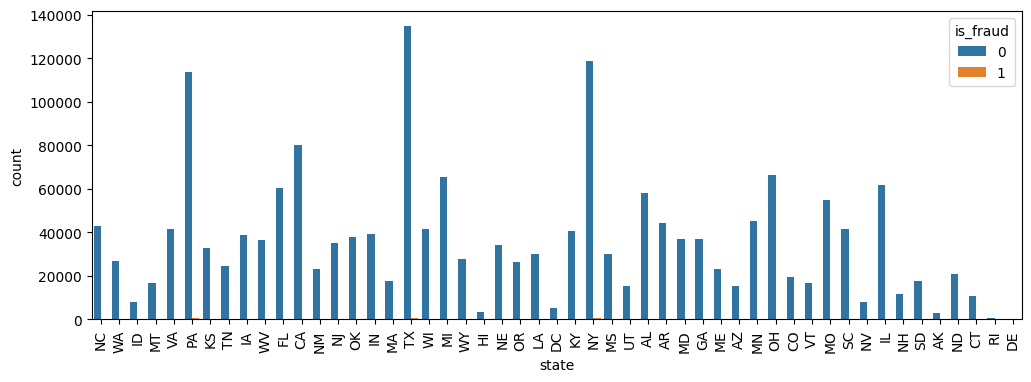

In [ ]:
# EDA for state vs transactions

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)

graph = sns.countplot(data=fraud_df, x="state", hue="is_fraud")
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

plt.show()

None # To skip label objects

Looking at the graph most number of transactions are noted in 3 states (PA, TX and NY).

In [ ]:
# Moving towards category feature
fraud_df.category.value_counts()

gas_transport     188029
grocery_pos       176191
home              175460
shopping_pos      166463
kids_pets         161727
shopping_net      139322
entertainment     134118
food_dining       130729
personal_care     130085
health_fitness    122553
misc_pos          114229
misc_net           90654
grocery_net        64878
travel             57956
Name: category, dtype: int64

In [ ]:
# EDA for merchant column
len(fraud_df.merchant.unique())

fraud_df.merchant.value_counts()

fraud_Kilback LLC                        6262
fraud_Cormier LLC                        5246
fraud_Schumm PLC                         5195
fraud_Kuhn LLC                           5031
fraud_Boyer PLC                          4999
                                         ... 
fraud_Douglas, DuBuque and McKenzie      1101
fraud_Treutel-King                       1098
fraud_Satterfield-Lowe                   1095
fraud_Hahn, Douglas and Schowalter       1091
fraud_Ritchie, Bradtke and Stiedemann    1090
Name: merchant, Length: 693, dtype: int64

Here, we have 693 different merchants and looking at the distribution it looks almost the same. In other words is very few variation in the number of transactions among all merchants.

## **Feature Encoding**

In [ ]:
# one-hot encoding for category and day of week
category_onehot = pd.get_dummies(fraud_df.category, prefix='category', drop_first=True)
day_of_week_onehot = pd.get_dummies(fraud_df.trans_day_of_week, prefix='day', drop_first=True)

# gender_onehot = pd.get_dummies(fraud_df.gender, prefix='gender', drop_first=True)
# age_onehot = pd.get_dummies(fraud_df.age, prefix='age', drop_first=True)

gender_mapping = {'F': 1.0, 'M': 2.0}
fraud_df['gender'] = fraud_df['gender'].map(gender_mapping)

In [ ]:
# Adding encoded columns to dataframne
fraud_data = pd.concat([fraud_df, category_onehot, day_of_week_onehot], axis=1)

# Dropping unnecessary columns due to low significance or having been encoded
fraud_data.drop([ 'cc_num', 'trans_num', 'merchant', 'street', 'city', 'state', 'job', 'first', 'last',
                 'category', 'trans_day_of_week'],axis=1, inplace=True)

print(fraud_data.shape)

(1852394, 32)


In [ ]:
fraud_data.head()

,amt,gender,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,...,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,4.97,1.0,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,...,0,0,0,0,0,0,0,0,1,0
1,107.23,1.0,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,...,0,0,0,0,0,0,0,0,1,0
2,220.11,2.0,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,...,0,0,0,0,0,0,0,0,1,0
3,45.00,2.0,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,...,0,0,0,0,0,0,0,0,1,0
4,41.96,2.0,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,...,0,0,0,0,0,0,0,0,1,0


<ipython-input-88-d08a9b954b11>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fraud_data.corr())


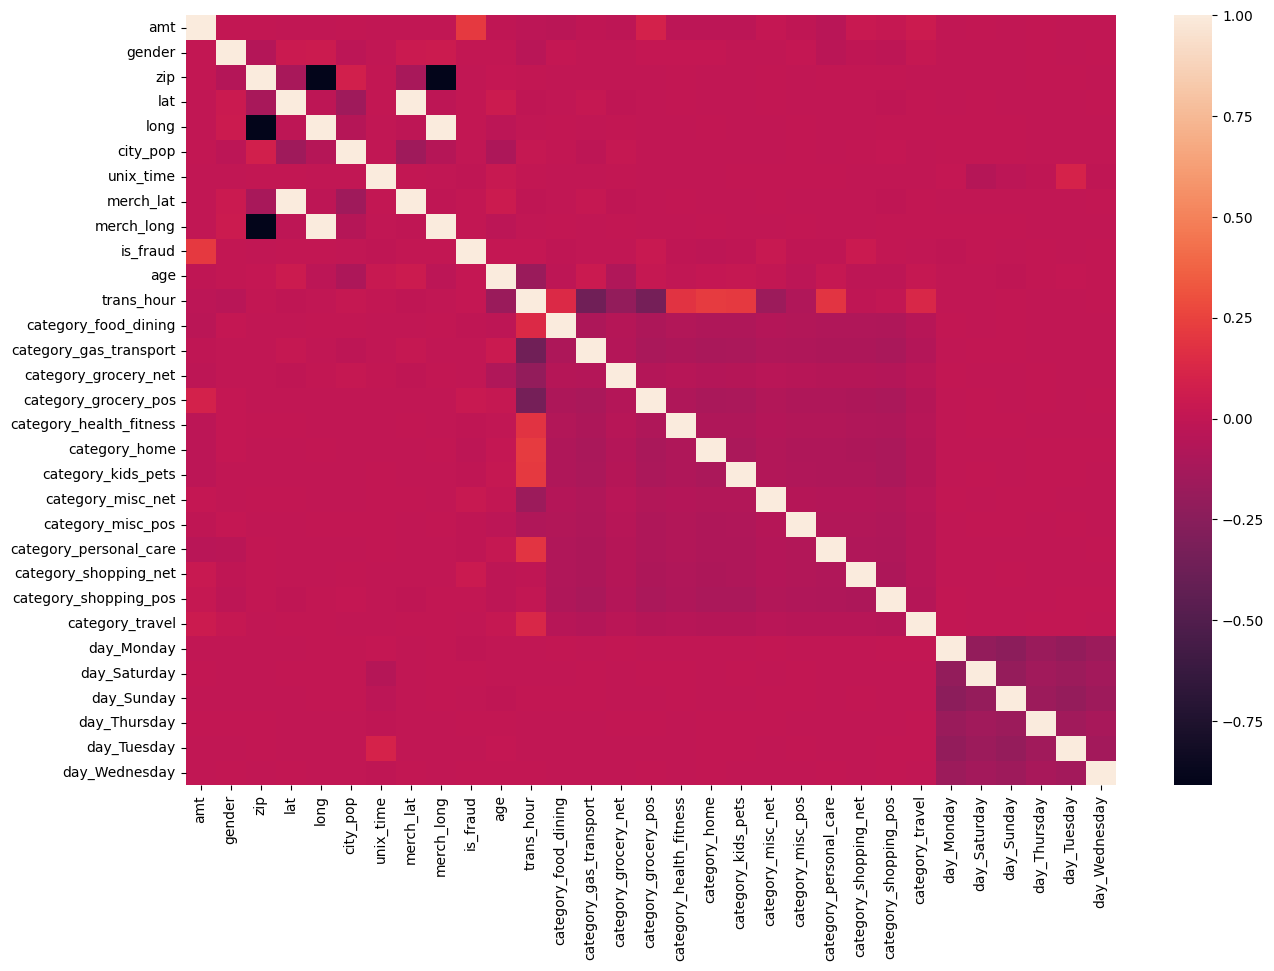

In [ ]:
# Checking correlations between the columns using heatmap
plt.figure(figsize=(15,10))
sns.heatmap(fraud_data.corr())
plt.show()

## **Balancing Data**

In [ ]:
fraud_data.drop(['zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'trans_year_month'],
                axis=1, inplace=True)

In [ ]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   gender                   float64
 2   is_fraud                 int64  
 3   age                      float64
 4   trans_hour               int64  
 5   category_food_dining     uint8  
 6   category_gas_transport   uint8  
 7   category_grocery_net     uint8  
 8   category_grocery_pos     uint8  
 9   category_health_fitness  uint8  
 10  category_home            uint8  
 11  category_kids_pets       uint8  
 12  category_misc_net        uint8  
 13  category_misc_pos        uint8  
 14  category_personal_care   uint8  
 15  category_shopping_net    uint8  
 16  category_shopping_pos    uint8  
 17  category_travel          uint8  
 18  day_Monday               uint8  
 19  day_Saturday             uint8  
 20  day_Sunday               uint8  
 21  day_Thur

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
fraud_data.to_csv('credit_card_processed_data.csv')
!cp credit_card_processed_data.csv "drive/My Drive/MIS637"

# Now, you can use processed data from the generated csv file and implement models

In [ ]:
fraud_data = fraud_data.dropna(subset=['is_fraud'])
# Storing target variable count

non_fraud_count, fraud_count = fraud_data.is_fraud.value_counts()
print(non_fraud_count, fraud_count)

#storing all fraud transactions
fraud_trans = fraud_data[fraud_data['is_fraud'] == 1]
non_fraud_trans = fraud_data[fraud_data['is_fraud'] == 0]

1842743 9651


In [ ]:
#input-output split
X = fraud_data.drop(['is_fraud'],axis=1)
y = fraud_data.is_fraud

In [ ]:
#scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1296675, 23)
(1296675,)
(555719, 23)
(555719,)


## **Logistic Regression without balancing dataset**

In [ ]:
# Implementing logistic regression
lr = LogisticRegression(random_state=42)

# Creating model
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('y_train_pred: ', y_train_pred)

y_test_pred = model.predict(X_test)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0 0 0 ... 0 0 0]
y_test_pred:  [0 0 0 ... 0 0 0]


In [ ]:
# Evaluating the model
model_name = 'Logistic Regression - Without Balancing'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)

# Creating a dataframe
model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall]]
temp_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
temp_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - Without Balancing,0.994466,0.994378,0.994378,0.991936,0.039604,0.002723


## Sampling Data

In [ ]:
# We have 3 different methods to remove biasness from dataset

# Random under sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)
print(y_rus.value_counts())

# Random Oversampling
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
print(y_ros.value_counts())

# SMOTE method
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X.astype('float'), y)
print(y_sm.value_counts)

0    9651
1    9651
Name: is_fraud, dtype: int64
0    1842743
1    1842743
Name: is_fraud, dtype: int64
<bound method IndexOpsMixin.value_counts of 0          0
1          0
2          0
3          0
4          0
          ..
3685481    1
3685482    1
3685483    1
3685484    1
3685485    1
Name: is_fraud, Length: 3685486, dtype: int64>


We, will be using SMOTE method.

In [ ]:
# Checking Target/Class variable frequency distribution
print(y_sm.value_counts())

0    1842743
1    1842743
Name: is_fraud, dtype: int64


In [ ]:
# Splitting data into training and testing dataset
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size = 0.3, random_state = 0)

## Logistic Regression

In [ ]:
# Implementing logistic regression
lr = LogisticRegression(random_state=42)

# Creating model
model = lr.fit(X_train_sm, y_train_sm)
y_train_pred = model.predict(X_train_sm)
print('y_train_pred: ', y_train_pred)

y_test_pred = model.predict(X_test_sm)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0 0 1 ... 1 0 0]
y_test_pred:  [0 0 0 ... 0 0 0]


In [ ]:
#evaluating the model
model_name = 'Logistic Regression - SMOTE'
train_score = model.score(X_train_sm,y_train_sm)
test_score = model.score(X_test_sm,y_test_sm)

acc_score = accuracy_score(y_test_sm, y_test_pred)
f_score = f1_score(y_test_sm, y_test_pred, average='weighted')
precision = precision_score(y_test_sm, y_test_pred)
recall = metrics.recall_score(y_test_sm, y_test_pred)

# Creating a dataframe
model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall]]
model_eval_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
model_eval_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - SMOTE,0.818679,0.819201,0.819201,0.818473,0.866254,0.755536


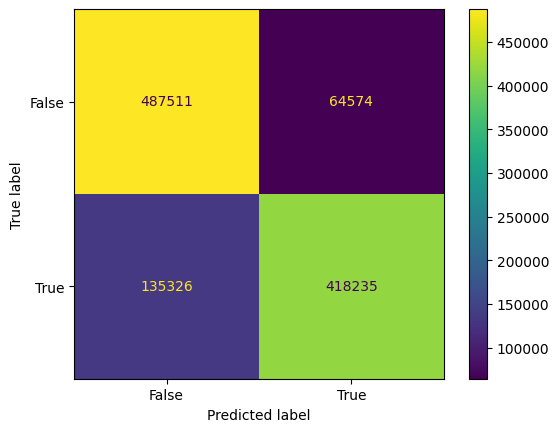

In [ ]:
cm = metrics.confusion_matrix(y_test_sm, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

## Gaussian Naive Bayes

In [ ]:
# Implementing GaussianNB
model = GaussianNB()

model.fit(X_train_sm, y_train_sm)
y_train_pred = model.predict(X_train_sm)
print('y_train_pred: ', y_train_pred)

y_test_pred = model.predict(X_test_sm)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0 0 1 ... 1 0 0]
y_test_pred:  [1 0 0 ... 0 1 0]


In [ ]:
#evaluating the model
model_name = 'Gaussian Naive Bayes - SMOTE'
train_score = model.score(X_train_sm,y_train_sm)
test_score = model.score(X_test_sm,y_test_sm)

acc_score = accuracy_score(y_test_sm, y_test_pred)
f_score = f1_score(y_test_sm, y_test_pred, average='weighted')
precision = precision_score(y_test_sm, y_test_pred)
recall = metrics.recall_score(y_test_sm, y_test_pred)

#creating a dataframe to compare the performance of different models
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {model_eval_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
model_eval_df = model_eval_df.append(model_eval_dict, ignore_index=True)

model_eval_df

<ipython-input-106-154ec5c0558c>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_eval_df = model_eval_df.append(model_eval_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - SMOTE,0.818679,0.819201,0.819201,0.818473,0.866254,0.755536
1,Gaussian Naive Bayes - SMOTE,0.687947,0.688138,0.688138,0.686966,0.668218,0.748998


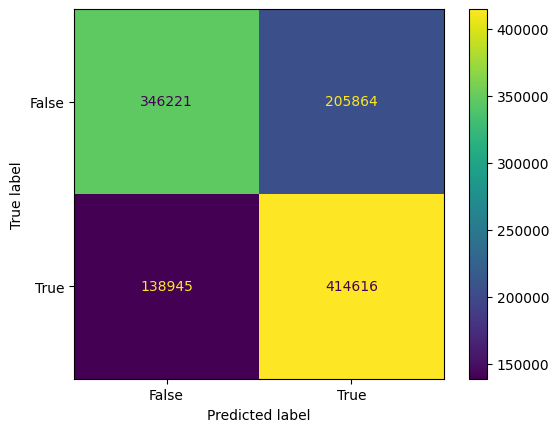

In [ ]:
cm = metrics.confusion_matrix(y_test_sm, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

## Decision Tree

In [ ]:
# Implementing Decision Tree Classifier
model = tree.DecisionTreeClassifier()

model.fit(X_train_sm, y_train_sm)
y_train_pred = model.predict(X_train_sm)
print('y_train_pred: ', y_train_pred)

y_test_pred = model.predict(X_test_sm)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0 0 1 ... 1 0 0]
y_test_pred:  [0 1 0 ... 1 0 1]


In [ ]:
#evaluating the model
model_name = 'Decision Tree Classifier - SMOTE'
train_score = model.score(X_train_sm,y_train_sm)
test_score = model.score(X_test_sm,y_test_sm)

acc_score = accuracy_score(y_test_sm, y_test_pred)
f_score = f1_score(y_test_sm, y_test_pred, average='weighted')
precision = precision_score(y_test_sm, y_test_pred)
recall = metrics.recall_score(y_test_sm, y_test_pred)

#creating a dataframe to compare the performance of different models
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {model_eval_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
model_eval_df = model_eval_df.append(model_eval_dict, ignore_index=True)

model_eval_df

<ipython-input-109-42da755a6868>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_eval_df = model_eval_df.append(model_eval_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - SMOTE,0.818679,0.819201,0.819201,0.818473,0.866254,0.755536
1,Gaussian Naive Bayes - SMOTE,0.687947,0.688138,0.688138,0.686966,0.668218,0.748998
2,Decision Tree Classifier - SMOTE,1.000000,0.997303,0.997303,0.997303,0.996808,0.997809


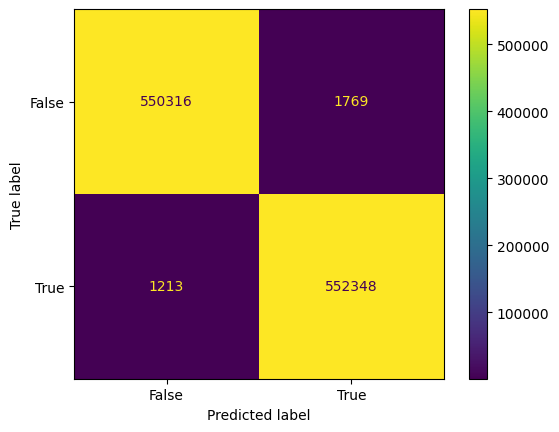

In [ ]:
cm = metrics.confusion_matrix(y_test_sm, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

## Random Forest Classifier

In [ ]:
# Implementing Random Forest Classifier
model = RandomForestClassifier()

model.fit(X_train_sm, y_train_sm)
y_train_pred = model.predict(X_train_sm)
print('y_train_pred: ', y_train_pred)

y_test_pred = model.predict(X_test_sm)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0 0 1 ... 1 0 0]
y_test_pred:  [0 1 0 ... 1 0 1]


In [ ]:
#evaluating the model
model_name = 'Random Forest Classifier - SMOTE'
train_score = model.score(X_train_sm,y_train_sm)
test_score = model.score(X_test_sm,y_test_sm)

acc_score = accuracy_score(y_test_sm, y_test_pred)
f_score = f1_score(y_test_sm, y_test_pred, average='weighted')
precision = precision_score(y_test_sm, y_test_pred)
recall = metrics.recall_score(y_test_sm, y_test_pred)

#creating a dataframe to compare the performance of different models
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {model_eval_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
model_eval_df = model_eval_df.append(model_eval_dict, ignore_index=True)

model_eval_df

In [ ]:
cm = metrics.confusion_matrix(y_test_sm, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,5), dpi=200)
rm_tree = tree.plot_tree(model.estimators_[0], filled=True)

## KNN

In [ ]:
# Splitting data into training and testing dataset
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size = 0.3, random_state = 0)

# No of nearest neighbores (KNN)
n = 3

# Creating instance of classifier
model = KNeighborsClassifier(n)

model.fit(X_train_rus, y_train_rus)
y_train_pred = model.predict(X_train_rus)
print('y_train_pred: ', y_train_pred)

y_test_pred = model.predict(X_test_rus)
print('y_test_pred: ', y_test_pred)

In [ ]:
#evaluating the model
model_name = 'KNN - RUS'
train_score = model.score(X_train_rus,y_train_rus)
test_score = model.score(X_test_rus,y_test_rus)

acc_score = accuracy_score(y_test_rus, y_test_pred)
f_score = f1_score(y_test_rus, y_test_pred, average='weighted')
precision = precision_score(y_test_rus, y_test_pred)
recall = metrics.recall_score(y_test_rus, y_test_pred)

#creating a dataframe to compare the performance of different models
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]

# Creating a dataframe
model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall]]
model_eval_rus_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
model_eval_rus_df

In [ ]:
cm = metrics.confusion_matrix(y_test_rus, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

## Support Vector Machine

In [ ]:
# Implementing SVC
model = SVC()

model.fit(X_train_rus, y_train_rus)
y_train_pred = model.predict(X_train_rus)
print('y_train_pred: ', y_train_pred)

y_test_pred = model.predict(X_test_rus)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.

In [ ]:
#evaluating the model
model_name = 'SVM - RUS'
train_score = model.score(X_train_rus,y_train_rus)
test_score = model.score(X_test_rus,y_test_rus)

acc_score = accuracy_score(y_test_rus, y_test_pred)
f_score = f1_score(y_test_rus, y_test_pred, average='weighted')
precision = precision_score(y_test_rus, y_test_pred)
recall = metrics.recall_score(y_test_rus, y_test_pred)

#creating a dataframe to compare the performance of different models
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {model_eval_rus_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
model_eval_rus_df = model_eval_rus_df.append(model_eval_dict, ignore_index=True)

model_eval_rus_df

In [ ]:
cm = metrics.confusion_matrix(y_test_rus, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()